In [0]:
!pip install fastai==0.7.0

In [0]:
!curl 'https://datahack-prod.s3.amazonaws.com/train_zip/train_oSwQCTC.zip' -H 'User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:69.0) Gecko/20100101 Firefox/69.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://datahack.analyticsvidhya.com/contest/black-friday/' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -o train.zip
!curl 'https://datahack-prod.s3.amazonaws.com/test_zip/test_HujdGe7.zip' -H 'User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:69.0) Gecko/20100101 Firefox/69.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://datahack.analyticsvidhya.com/contest/black-friday/' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -o test.zip
!unzip train.zip
!unzip test.zip

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.structured import *
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy as hc

In [0]:
df_raw = pd.read_csv("train.csv", low_memory=False)
test_data = pd.read_csv("test.csv", low_memory=False)

In [0]:
df_raw.head().T

,0,1,2,3,4
User_ID,1000001,1000001,1000001,1000001,1000002
Product_ID,P00069042,P00248942,P00087842,P00085442,P00285442
Gender,F,F,F,F,M
Age,0-17,0-17,0-17,0-17,55+
Occupation,10,10,10,10,16
City_Category,A,A,A,A,C
Stay_In_Current_City_Years,2,2,2,2,4+
Marital_Status,0,0,0,0,0
Product_Category_1,3,1,12,12,8
Product_Category_2,NaN,6,NaN,14,NaN


In [0]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
User_ID,550068.0,1.003029e+06,1727.591586,1000001.0,1001516.0,1003077.0,1004478.0,1006040.0
Occupation,550068.0,8.076707e+00,6.522660,0.0,2.0,7.0,14.0,20.0
Marital_Status,550068.0,4.096530e-01,0.491770,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,5.404270e+00,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,9.842329e+00,5.086590,2.0,5.0,9.0,15.0,18.0
Product_Category_3,166821.0,1.266824e+01,4.125338,3.0,9.0,14.0,16.0,18.0
Purchase,550068.0,9.263969e+03,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


In [0]:
# Appending test data for same preprocessing and assigning Purchase = 0(as 0 is not in any train eg.) so can be easily filtered out later
test_data['Purchase'] = 0
df_with_test = df_raw.append(test_data)

In [0]:
# unique value count, overall count, null values count (in each column)
z = df_with_test.apply([lambda x: x.nunique(), lambda x: x.count(), lambda x: x.isnull().sum(),
                 lambda x: x.dtype]).T
z.columns = ['unique_count', 'all_count', 'null_count', 'data_type']
z

,unique_count,all_count,null_count,data_type
User_ID,5891,783667,0,int64
Product_ID,3677,783667,0,object
Gender,2,783667,0,object
Age,7,783667,0,object
Occupation,21,783667,0,int64
City_Category,3,783667,0,object
Stay_In_Current_City_Years,5,783667,0,object
Marital_Status,2,783667,0,int64
Product_Category_1,20,783667,0,int64
Product_Category_2,17,537685,245982,float64


In [0]:
df_with_test.fillna(999, inplace=True)
df_with_test.head().T

,0,1,2,3,4
User_ID,1000001,1000001,1000001,1000001,1000002
Product_ID,P00069042,P00248942,P00087842,P00085442,P00285442
Gender,F,F,F,F,M
Age,0-17,0-17,0-17,0-17,55+
Occupation,10,10,10,10,16
City_Category,A,A,A,A,C
Stay_In_Current_City_Years,2,2,2,2,4+
Marital_Status,0,0,0,0,0
Product_Category_1,3,1,12,12,8
Product_Category_2,999,6,999,14,999


In [0]:
df_with_test.loc[:, df_with_test.columns != 'Purchase'] = df_with_test.drop(
    'Purchase', axis=1).applymap(str)
df_with_test.dtypes

User_ID                       object
Product_ID                    object
Gender                        object
Age                           object
Occupation                    object
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                object
Product_Category_1            object
Product_Category_2            object
Product_Category_3            object
Purchase                       int64
dtype: object

In [0]:
# lbl_enc = preprocessing.LabelEncoder()
# df_with_test.loc[:, df_with_test.columns != 'Purchase'] = df_with_test.loc[
#     :, df_with_test.columns != 'Purchase'].apply(lbl_enc.fit_transform)
train_cats(df_with_test)
df_with_test, _, nas = proc_df(df_with_test, max_n_cat=7)

In [0]:
# removing test data
train_df = df_with_test[df_with_test.Purchase>0]
test_df = df_with_test[df_with_test.Purchase==0].drop(['Purchase'], axis=1)

In [0]:
uf = train_df.groupby(['User_ID'], as_index=False).Product_ID.count()
uf.columns = ['User_ID', 'uf']
train_df = pd.merge(train_df, uf, how='left', on='User_ID')
test_df = pd.merge(test_df, uf, how='left', on='User_ID')
pf = train_df.groupby(['Product_ID'], as_index=False).User_ID.count()
pf.columns = ['Product_ID', 'pf']
train_df = pd.merge(train_df, pf, how='left', on='Product_ID')
test_df = pd.merge(test_df, pf, how='left', on='Product_ID')
pm = train_df.groupby(['Product_ID'], as_index=False).Purchase.mean()
pm.columns = ['Product_ID', 'pm']
train_df = pd.merge(train_df, pm, how='left', on='Product_ID')
test_df = pd.merge(test_df, pm, how='left', on='Product_ID')

In [0]:
train_df['uhf'] = np.where(train_df.Purchase>train_df.pm, 1, 0)
uh = train_df.groupby(['User_ID'], as_index=False).uhf.mean()
uh.columns = ['Product_ID', 'uh']
train_df = pd.merge(train_df, uh, how='left', on='Product_ID')
train_df = train_df.drop(['uhf'], axis=1)
test_df = pd.merge(test_df, uh, how='left', on='Product_ID')

In [0]:
test_df.fillna(0, inplace=True)
test_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,233559,233560,233561,233562,233563,233564,233565,233566,233567,233568,233569,233570,233571,233572,233573,233574,233575,233576,233577,233578,233579,233580,233581,233582,233583,233584,233585,233586,233587,233588,233589,233590,233591,233592,233593,233594,233595,233596,233597,233598
User_ID,4.00000,9.000000,10.000000,10.000000,11.000000,13.000000,13.000000,13.000000,15.000000,22.000000,26.000000,26.000000,26.000000,26.000000,28.000000,29.000000,33.000000,33.000000,34.000000,35.000000,36.00000,36.000000,40.000000,43.000000,43.000000,43.000000,46.000000,46.000000,51.000000,51.000000,51.000000,51.000000,51.000000,57.000000,60.000000,61.000000,61.000000,63.000000,66.000000,67.000000,...,5828.000000,5831.000000,5831.000000,5832.000000,5838.000000,5841.000000,5843.000000,5843.000000,5845.000000,5845.000000,5847.000000,5847.000000,5852.000000,5853.000000,5853.000000,5853.000000,5853.000000,5854.000000,5861.000000,5864.000000,5867.000000,5867.000000,5869.000000,5872.000000,5872.000000,5874.000000,5876.000000,5877.000000,5879.000000,5881.000000,5881.000000,5883.000000,5884.000000,5886.000000,5887.000000,5887.000000,5887.000000,5887.000000,5888.000000,5890.000000
Product_ID,1217.00000,1064.000000,2800.000000,1380.000000,536.000000,3408.000000,1481.000000,3623.000000,1544.000000,674.000000,465.000000,398.000000,1888.000000,45.000000,1521.000000,1045.000000,1140.000000,3349.000000,2569.000000,3644.000000,2943.00000,593.000000,306.000000,3368.000000,3476.000000,2763.000000,1038.000000,2434.000000,1295.000000,3651.000000,1606.000000,3447.000000,980.000000,1697.000000,1122.000000,2520.000000,1066.000000,1.000000,2083.000000,1502.000000,...,3255.000000,844.000000,576.000000,2836.000000,512.000000,1697.000000,2124.000000,2414.000000,2987.000000,981.000000,1765.000000,451.000000,1175.000000,1141.000000,2254.000000,2183.000000,2764.000000,3043.000000,2155.000000,201.000000,146.000000,1025.000000,709.000000,1055.000000,34.000000,2540.000000,1537.000000,1037.000000,1550.000000,1226.000000,2332.000000,2442.000000,1205.000000,1285.000000,2472.000000,1119.000000,2464.000000,316.000000,1176.000000,3075.000000
Occupation,19.00000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,19.000000,8.000000,19.000000,19.000000,19.000000,19.000000,2.000000,19.000000,15.000000,15.000000,1.000000,2.000000,15.00000,15.000000,20.000000,9.000000,9.000000,9.000000,16.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,15.000000,16.000000,16.000000,5.000000,16.000000,2.000000,...,2.000000,2.000000,2.000000,19.000000,9.000000,14.000000,16.000000,16.000000,2.000000,2.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,14.000000,2.000000,2.000000,2.000000,5.000000,5.000000,1.000000,2.000000,18.000000,16.000000,10.000000,10.000000,19.000000,6.000000,2.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000
Product_Category_1,1.00000,14.000000,16.000000,15.000000,15.000000,12.000000,1.000000,12.000000,2.000000,16.000000,1.000000,16.000000,16.000000,16.000000,2.000000,12.000000,7.000000,16.000000,16.000000,12.000000,16.00000,1.000000,1.000000,1.000000,16.000000,16.000000,1.000000,1.000000,1.000000,1.000000,16.000000,16.000000,16.000000,1.000000,10.000000,16.000000,19.000000,14.000000,14.000000,19.000000,...,17.000000,2.000000,1.000000,19.000000,19.000000,1.000000,16.000000,14.000000,1.000000,1.000000,20.000000,1.000000,8.000000,19.000000,1.000000,3.000000,1.000000,16.000000,1.000000,1.000000,1.000000,19.000000,7.000000,1.000000,15.000000,1.000000,3.000000,1.000000,1.000000,17.000000,12.000000,19.000000,1.000000,17.000000,19.000000,19.000000,16.000000,1.000000,2.000000,15.000000
Product_Category_2,2.00000,13.000000,5.000000,17.000000,13.000000,11.000000,2.000000,12.000000,4.000000,5.000000,10.000000,18.000000,16.000000,16.000000,6.000000,8.000000,18.000000,16.000000,16.000000,11.000000,18.0000

In [0]:
y = train_df['Purchase']
train_df = train_df.drop(['Purchase', 'Product_ID'], axis=1)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, test_size=0.3, random_state=1)

In [0]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)  

In [0]:
m = RandomForestRegressor(
    n_jobs=-1, n_estimators=40, max_features='sqrt', min_samples_leaf=3, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 8.2 s
[2480.64050325535, 2614.8352617855053, 0.7559359603200965, 0.7294654590626739, 0.7271451511579383]


In [0]:
set_rf_samples(50000)
#reset_rf_samples()

In [0]:
m = RandomForestRegressor(
    n_jobs=-1, n_estimators=40, max_features='sqrt', min_samples_leaf=3, oob_score=False)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7.76 s, sys: 0 ns, total: 7.76 s
Wall time: 2.1 s
[2477.1964695460456, 2613.0521930571385, 0.7566131896675546, 0.7298342908722684]


In [0]:
fi = rf_feat_importance(m, X_train); fi

,cols,imp
31,pm,0.543495
2,Product_Category_1,0.188483
30,pf,0.067487
4,Product_Category_3,0.038280
29,uf,0.026990
32,uh,0.026364
3,Product_Category_2,0.025905
0,User_ID,0.024256
1,Occupation,0.015935
21,Stay_In_Current_City_Years_1,0.003489


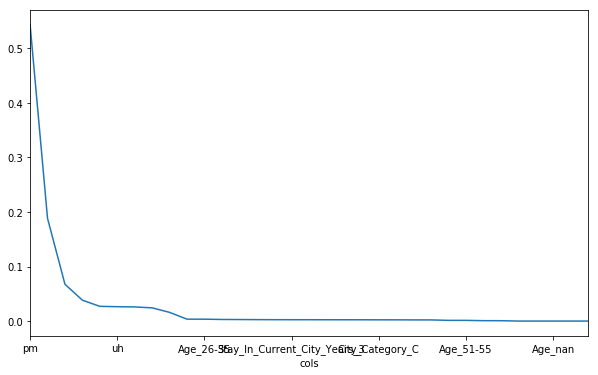

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

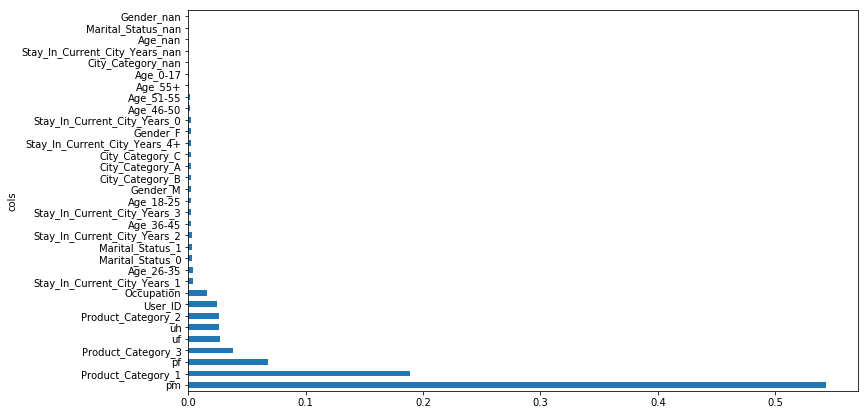

In [0]:
plot_fi(fi);

In [0]:
to_keep = fi[fi.imp>0].cols; len(to_keep)

28

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, test_size=0.3, random_state=1)
X_train, X_valid = X_train[to_keep], X_valid[to_keep]

In [0]:
#reset_rf_samples()
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=False)
m.fit(X_train, y_train)
print_score(m)

[2396.1363117794253, 2594.992836198839, 0.7722810484228098, 0.7335557312618017]


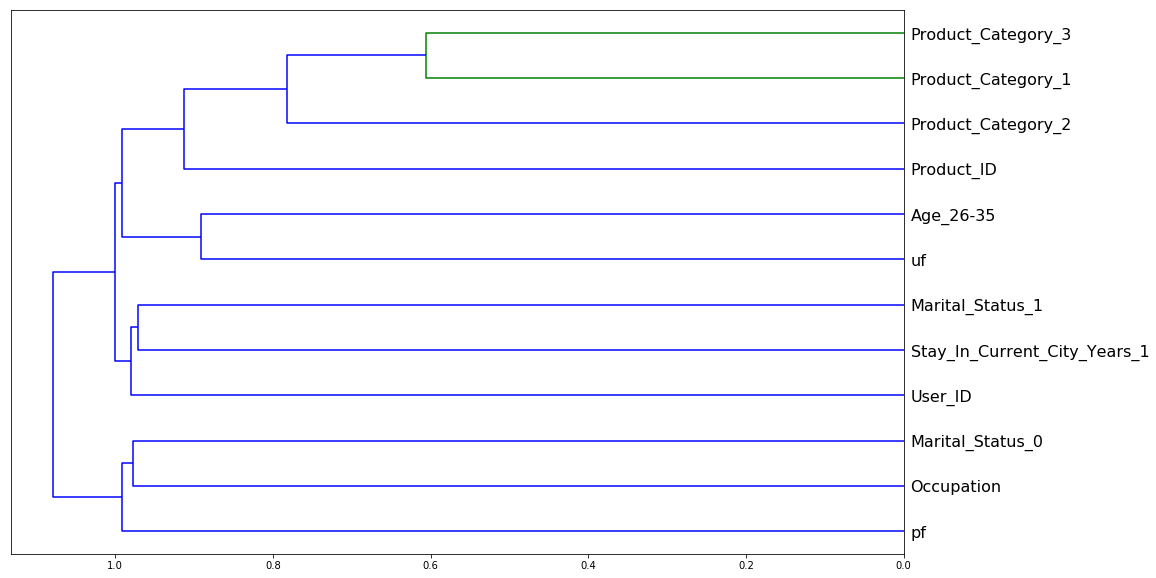

In [0]:
corr = np.round(scipy.stats.spearmanr(train_df[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train_df[to_keep].columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:
from sklearn.neural_network import MLPRegressor
m_nn = MLPRegressor(hidden_layer_sizes=(30), activation='logistic')
m_nn.fit(X_train, y_train)
print_score(m_nn)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[4127.739740889881, 4129.780928190006, 0.32422713715815243, 0.3251797832116333]


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

ker_m = Sequential()
ker_m.add(Dense(25, input_dim=12, activation='relu', kernel_initializer='he_uniform'))
ker_m.add(Dense(25, activation='relu'))
ker_m.add(Dense(25, activation='relu'))
ker_m.add(Dense(25, activation='relu'))
# ker_m.add(Dense(4, activation='relu'))
# ker_m.add(Dense(4, activation='relu'))
# ker_m.add(Dense(4, activation='relu'))
ker_m.add(Dense(1, activation='linear'))
#opt = SGD(lr=0.01, momentum=0.9)
ker_m.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# fit model
history = ker_m.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100)
# evaluate the keras model
_, accuracy = ker_m.evaluate(X_valid, y_valid)
print('Accuracy: %.2f' % (accuracy*100))

Train on 385047 samples, validate on 165021 samples
Epoch 1/100
385047/385047 [==============================] - 69s 178us/step - loss: 7394887.2140 - acc: 2.0517e-04 - val_loss: 7123941.2338 - val_acc: 2.1815e-04
Epoch 2/100
385047/385047 [==============================] - 67s 175us/step - loss: 7076230.9987 - acc: 2.0517e-04 - val_loss: 7002936.5752 - val_acc: 3.0299e-04
Epoch 3/100
385047/385047 [==============================] - 67s 174us/step - loss: 7065587.8753 - acc: 2.4672e-04 - val_loss: 6990896.2528 - val_acc: 2.2421e-04
Epoch 4/100
385047/385047 [==============================] - 66s 173us/step - loss: 7054467.2816 - acc: 2.4932e-04 - val_loss: 7008430.7930 - val_acc: 3.0905e-04
Epoch 5/100
385047/385047 [==============================] - 67s 174us/step - loss: 7055361.2616 - acc: 2.4153e-04 - val_loss: 7064265.8646 - val_acc: 2.0603e-04
Epoch 6/100
324032/385047 [========================>.....] - ETA: 9s - loss: 7054711.4873 - acc: 2.7466e-04

KeyboardInterrupt: ignored

In [0]:
np.array(X_train).shape

(385047, 12)

In [0]:
out = test_data.copy()
out["Purchase"] = m.predict(test_df)
out[['User_ID', 'Product_ID', 'Purchase']].to_csv('test_results.csv', index=False)

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
Purchase                           0
Comb                               0
dtype: int64

In [0]:
X_train.T

,396797,316599,428580,387279,421397,254704,316526,490328,478430,488067,424701,35737,158822,394693,211878,349316,476317,46378,306322,62410,365997,250890,264192,99094,69091,295519,87319,334941,507892,339850,281025,140317,27006,10629,208088,416741,328907,43351,465896,396879,...,540565,99782,205895,506312,432755,58072,357640,194769,323900,128896,369977,117565,99335,296022,444256,26103,148209,412649,294103,246322,188317,365212,401660,457611,176485,21758,513300,167302,293372,436973,413825,229520,21440,117583,73349,371403,491263,470924,491755,128037
Product_Category_1,19,16,16,19,16,12,1,17,3,18,12,19,1,16,16,19,15,19,7,16,19,2,1,1,19,1,16,1,4,16,7,12,16,1,5,12,1,1,17,14,...,1,16,16,16,1,1,16,19,16,3,16,3,8,6,1,12,15,16,16,16,1,3,16,16,16,16,16,16,1,1,16,3,19,16,19,19,1,16,16,19
pf,139,215,1091,319,269,322,2292,671,368,124,1362,886,195,308,719,122,57,1045,712,628,481,1397,513,2279,176,248,212,642,599,223,625,661,1185,1625,765,347,845,649,1308,95,...,1922,392,1181,935,859,710,1141,481,693,24,145,368,362,137,361,542,538,864,463,285,269,286,956,279,1690,249,80,606,697,1274,1141,13,96,418,525,619,1719,740,932,92
Product_ID,2485,2464,3157,687,244,2178,1037,1022,2433,3317,2874,854,1580,517,939,2952,1895,839,1040,3200,24,526,201,1051,433,3464,2594,1394,830,3295,3037,3362,2511,1055,1654,1859,2407,158,1054,1791,...,105,780,2319,3098,306,10,2399,24,2905,3588,116,1179,3460,28,2258,1101,1883,3125,1630,3128,1660,1167,2374,2769,345,1854,697,2388,983,1744,2399,3590,3420,3198,1069,257,795,2460,1326,2003
Product_Category_2,18,16,18,2,5,12,10,16,7,18,13,18,16,14,18,4,13,7,18,16,6,6,10,10,18,6,18,4,5,18,18,16,17,2,6,11,14,7,16,12,...,16,16,18,18,10,10,18,6,18,6,5,18,18,18,6,8,17,16,16,16,13,6,2,16,5,18,2,5,10,13,18,6,6,5,18,5,14,2,18,18
Product_Category_3,16,16,16,16,16,6,14,1,16,16,6,16,7,2,16,16,16,16,16,16,16,16,16,5,16,16,16,5,16,16,16,5,16,6,7,11,5,16,16,16,...,8,5,16,16,6,7,16,16,16,16,16,16,16,16,16,16,6,8,16,16,14,16,3,16,8,16,16,16,6,13,16,16,7,16,16,16,14,3,16,16
uf,538,241,66,170,187,450,72,542,1468,88,175,258,778,617,87,1021,377,383,63,120,34,74,453,19,44,143,17,265,649,220,247,78,298,618,138,571,180,498,558,606,...,33,157,53,405,206,498,593,52,359,42,372,203,35,135,50,431,500,184,110,363,374,250,246,495,285,387,115,558,13,153,243,687,472,340,33,71,41,186,29,435
User_ID,1075,799,5845,5456,4704,3229,785,3466,1635,3173,5253,5379,536,748,2666,5648,1315,1103,5058,3517,2223,2651,4544,3283,4433,3477,1416,3506,213,4188,1261,3577,4012,1588,1979,3987,2610,673,5617,1080,...,5112,3381,1690,5851,629,2883,1083,38,1809,1775,2933,136,3313,3538,2275,3906,4746,3435,3294,1868,4945,2097,1719,4299,3236,3332,1079,1761,3184,1228,3592,5257,3296,143,5169,3158,3581,542,3645,1653
Occupation,18,5,2,14,19,2,10,18,14,4,1,1,20,16,10,2,16,15,5,1,10,4,16,9,19,18,1,19,6,7,13,5,19,9,1,19,1,1,2,7,...,16,4,9,10,19,15,16,16,9,2,10,14,19,2,2,5,9,2,2,19,13,12,14,16,5,14,8,5,19,13,19,1,1,14,18,19,2,21,1,16
Stay_In_Current_City_Years_1,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,1
Age_26-35,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,1,1,1,1
